In [1]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

from gps_utils import haversine

%load_ext autoreload
%autoreload 2

In [2]:
with open('../gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
    
segment = gpx_file.tracks[0].segments[0]

### Let's try to correct some unrealistic things like

In [3]:
segment.get_uphill_downhill()

UphillDownhill(uphill=4446.100000000043, downhill=4439.100000000031)

### ... and speed records on a bikecycle

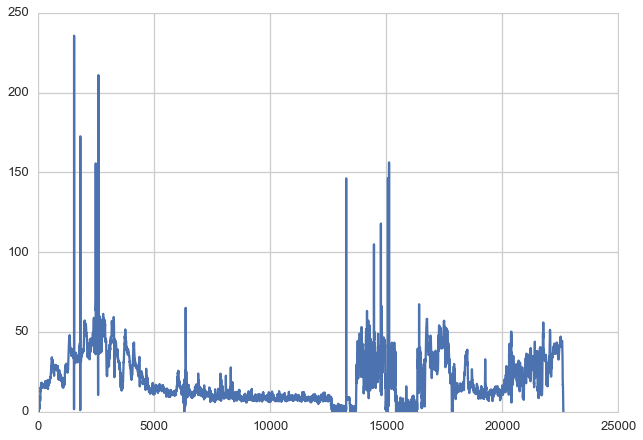

In [4]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

### But we start with a little bit of data wrangling

In [5]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'speed': p.speed,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.set_index('time', inplace=True)
coords.head()

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 04:31:27,1343.0,0,46.889062,10.502119,0.000000
2016-06-26 04:31:28,1343.0,1,46.889062,10.502119,0.018335
2016-06-26 04:31:29,1343.0,2,46.889062,10.502119,0.539877
2016-06-26 04:31:30,1344.0,3,46.889065,10.502119,1.062646
2016-06-26 04:31:31,1345.0,4,46.889068,10.502121,1.123059


In [6]:
coords.tail()

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 10:49:01.117,1350.0,22627,46.888570,10.502008,0.711726
2016-06-26 10:49:02.117,1350.0,22628,46.888573,10.502010,0.278200
2016-06-26 10:49:03.117,1350.0,22629,46.888574,10.502012,0.139867
2016-06-26 10:49:04.117,1350.0,22630,46.888574,10.502013,0.079782
2016-06-26 10:49:05.117,1350.0,22631,46.888575,10.502012,0.000000


### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [7]:
coords.index = np.round(coords.index.astype(np.int64), -9).astype('datetime64[ns]')
coords.tail()

,ele,idx,lat,lon,speed
2016-06-26 10:49:01,1350.0,22627,46.888570,10.502008,0.711726
2016-06-26 10:49:02,1350.0,22628,46.888573,10.502010,0.278200
2016-06-26 10:49:03,1350.0,22629,46.888574,10.502012,0.139867
2016-06-26 10:49:04,1350.0,22630,46.888574,10.502013,0.079782
2016-06-26 10:49:05,1350.0,22631,46.888575,10.502012,0.000000


### Do we have signal loss?

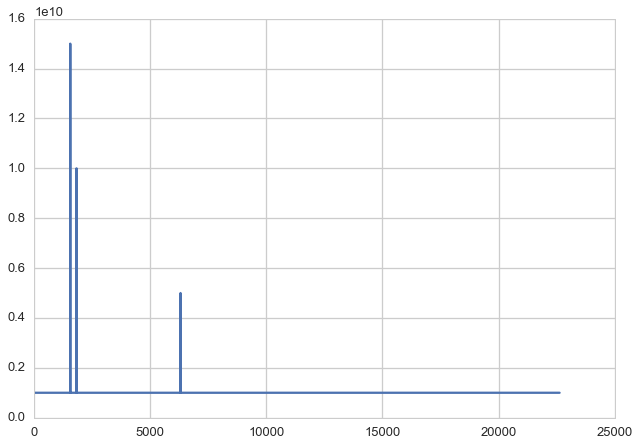

In [8]:
plt.plot(np.diff(coords.index))

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [9]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,ele,idx,lat,lon,speed
2016-06-26 04:57:17,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:18,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:19,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:20,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:21,NaN,NaN,NaN,NaN,NaN


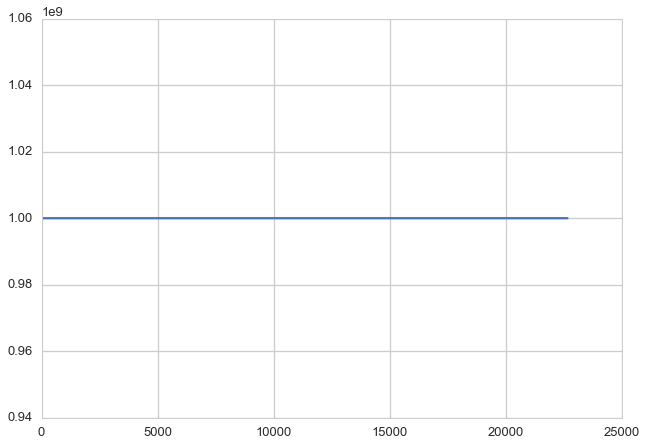

In [10]:
plt.plot(np.diff(coords.index))

### Almost done. Now convert to good old numpy array and mask NaNs

In [11]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)

### So where did I lose the GPS signal?

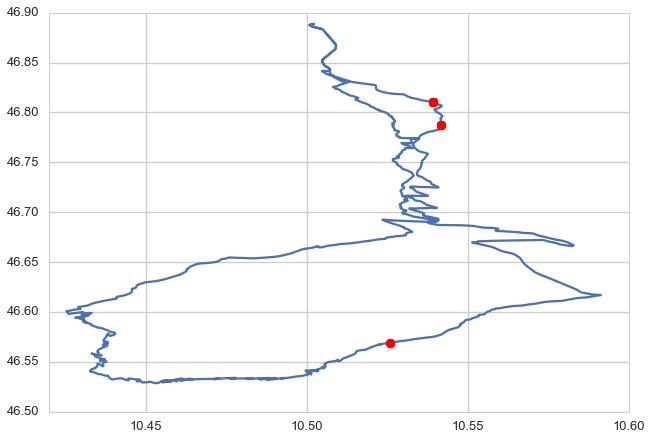

In [12]:
fig = plt.figure()
plt.plot(measurements[:,0], measurements[:,1])
filled_coords = coords.fillna(method='pad').ix[coords.ele.isnull()]
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'ro')

### Let's set up the Kalman Filter

In [13]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# works initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-6, 1e-6, 1e-6])**2

In [14]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

In [15]:
# Careful here, expectation maximation takes several hours!
#kf = kf.em(measurements, n_iter=1000)
# or just run this instead of the one above (it is the same result)
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
Q = 0.5*(Q + Q.T) # assure symmetry
kf.transition_covariance = Q

### Compare now our measurements with a smoothed track

In [16]:
state_means, state_vars = kf.smooth(measurements)

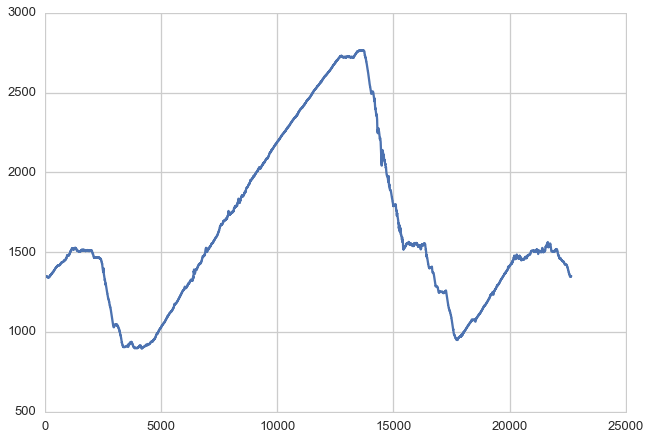

In [17]:
plt.plot(measurements[:,2])

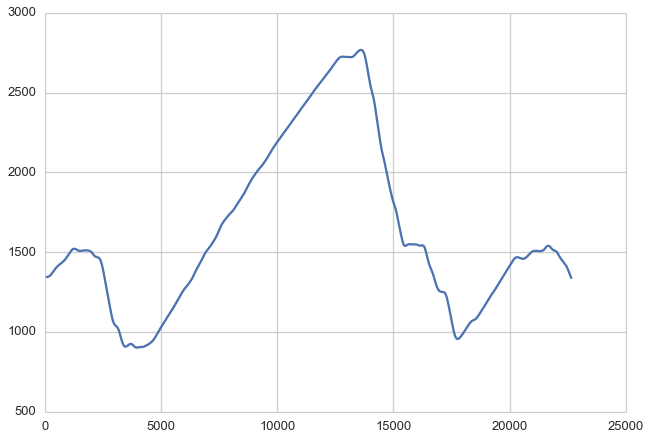

In [18]:
plt.plot(state_means[:,2])

### Let's write the smoothed data back into our dataframe and GPX file

In [19]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

In [20]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [21]:
segment.get_uphill_downhill()

UphillDownhill(uphill=2677.5293611031921, downhill=2683.5375577693385)

### Yes, that sounds much more realistic!!! Let's also check the speed

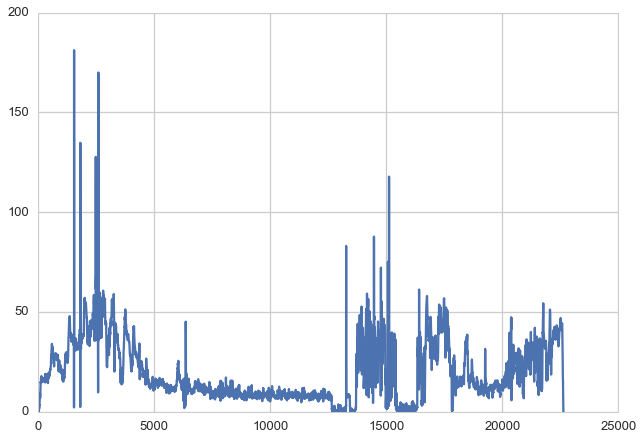

In [22]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

### Arrrggh!!! Still not good! What the heck is going on?

In [23]:
np.argsort(speed)[:-10:-1]

array([1553, 1552, 2599, 2598, 1551, 1554, 2600, 2597, 1822])

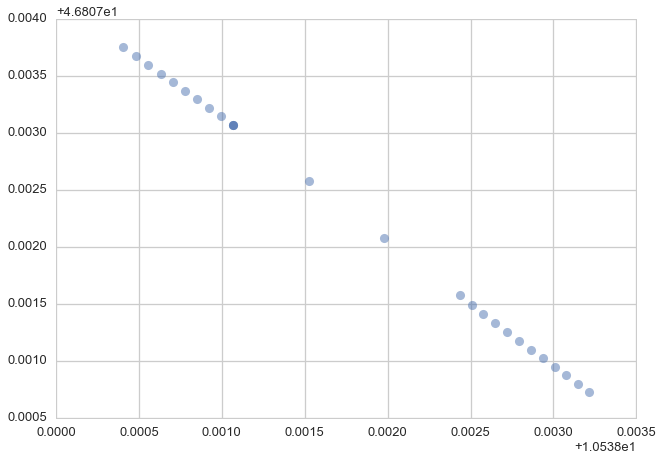

In [24]:
plt.plot(measurements[1540:1580,0], measurements[1540:1580,1], 'o', alpha=0.5)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

In [25]:
segment.points[1545:1558] # speed is in m/s

[GPXTrackPoint(46.8103637757, 10.5387835682, elevation=1508.193584207135, time=datetime.datetime(2016, 6, 26, 4, 57, 12), speed=10.433596343171985),
 GPXTrackPoint(46.8102864276, 10.5388611174, elevation=1508.2165744764188, time=datetime.datetime(2016, 6, 26, 4, 57, 13), speed=10.22185515140879),
 GPXTrackPoint(46.8102118765, 10.5389352308, elevation=1508.239971017472, time=datetime.datetime(2016, 6, 26, 4, 57, 14), speed=9.370366934816714),
 GPXTrackPoint(46.8101458484, 10.5389972135, elevation=1508.2645007525773, time=datetime.datetime(2016, 6, 26, 4, 57, 15), speed=7.296278012593184),
 GPXTrackPoint(46.810098998, 10.5390329171, elevation=1508.2914346143646, time=datetime.datetime(2016, 6, 26, 4, 57, 16), speed=0.5932080808036679),
 GPXTrackPoint(46.8101179798, 10.5389947776, elevation=1508.7808604716311, time=datetime.datetime(2016, 6, 26, 4, 57, 31), speed=2.2466641290849045),
 GPXTrackPoint(46.8098798432, 10.539238938, elevation=1508.7891390726277, time=datetime.datetime(2016, 6, 

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [26]:
bad_readings = np.argsort(np.trace(state_vars[:,:2,:2], axis1=1, axis2=2))[:-20:-1]
bad_readings = np.array([idx for idx in range(measurements.shape[0]) if np.min(np.abs(bad_readings - idx)) <= 5])
measurements.mask[bad_readings, :] = True 

In [27]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [28]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

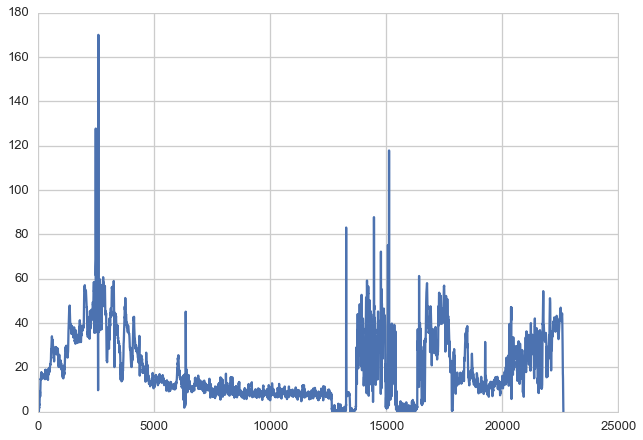

In [29]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

### We are getting there! Let's take a look where the problem is...

In [30]:
# calculate the speed directly on our array
speed = [3.6*haversine(state_means[i,1::-1], state_means[i+1,1::-1]) for i in np.arange(state_means.shape[0]-1)]
np.argsort(speed)[:-10:-1]

array([ 2621,  2622,  2620,  2508,  2509, 15147,  2619,  2623,  2507])

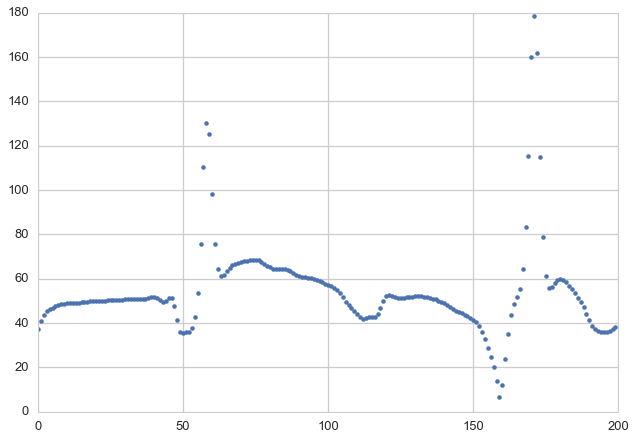

In [31]:
plt.plot(speed[2450:2650], '.')

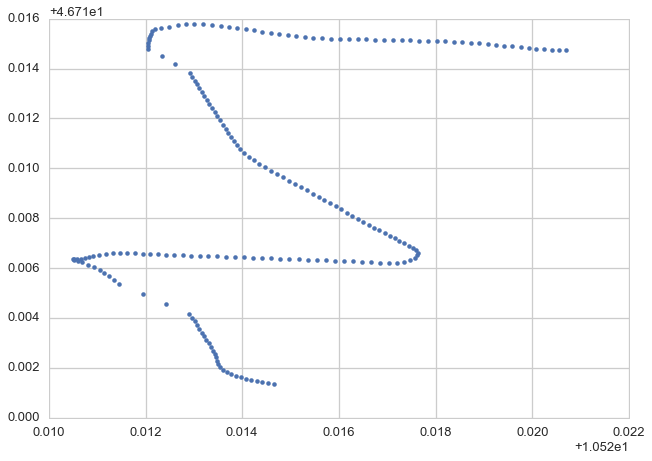

In [32]:
plt.plot(measurements[2450:2650,0], measurements[2450:2650,1], '.')

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

In [33]:
# we check for strong accelerations/deaccelarations
acc = np.gradient(speed)
outliers = np.argsort(np.abs(acc))[:-40:-1]
outliers

array([ 2623, 15149,  2619, 15145, 15101, 13299,  2622,  2620, 15146,
       13301, 15099, 15148, 13298,  2506, 15150,  2507,  2624, 15144,
       15098,  2618,  2510, 13302, 15102, 14795,  2511,  2505, 14796,
        2509, 16439, 14823, 13297, 15143,  2617, 14794, 15097, 16438,
       14824,  6385, 13303])

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [34]:
outliers = np.array([idx for idx in range(measurements.shape[0]) if np.min(np.abs(outliers - idx)) <= 12])
measurements.mask[outliers] = True
state_means, state_vars = kf.smooth(measurements)

In [35]:
# we smooth several times
for _ in range(10):
    state_means, state_vars = kf.smooth(state_means[:,:3])

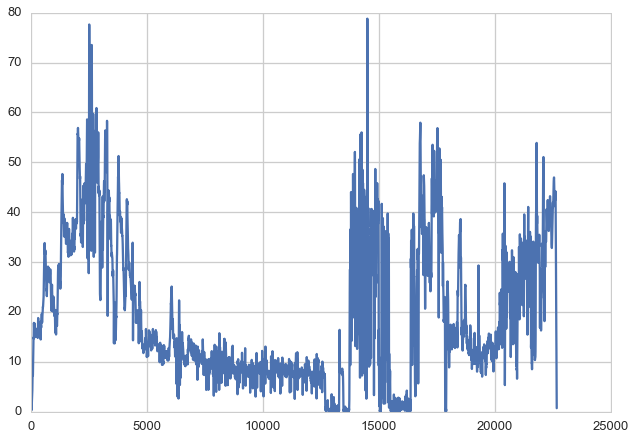

In [36]:
speed = [3.6*haversine(state_means[i,1::-1], state_means[i+1,1::-1]) for i in np.arange(state_means.shape[0]-1)]
plt.plot(speed)

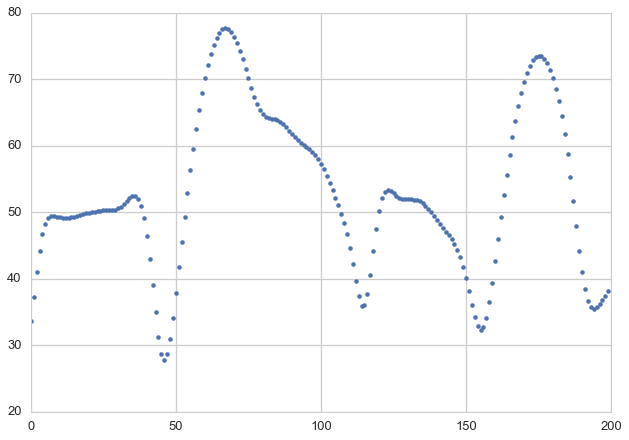

In [37]:
plt.plot(speed[2450:2650], '.')

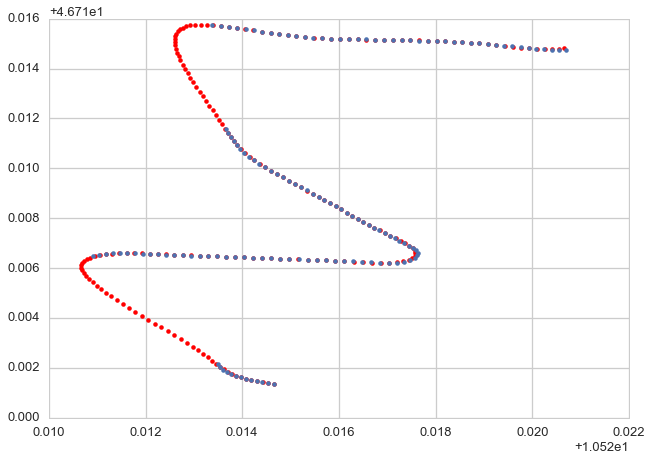

In [38]:
plt.plot(state_means[2450:2650,0], state_means[2450:2650,1], 'r.')
plt.plot(measurements[2450:2650,0], measurements[2450:2650,1], '.')

In [39]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

In [40]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [41]:
segment.get_uphill_downhill()

UphillDownhill(uphill=2598.7900974038143, downhill=2595.10654964988)

### Finally, write everything back to the GPX file

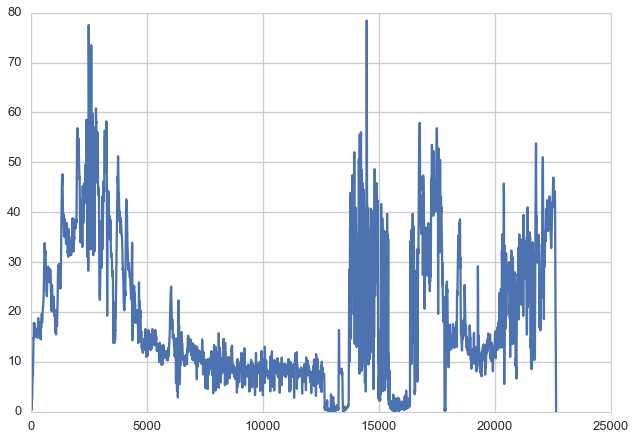

In [42]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()
speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

In [43]:
with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
    fh.write(gpx_file.to_xml())